# Function for extract the data from only one slice

In [2]:
# Install ReadVTK with: import Pkg; Pkg.add("ReadVTK")
using ReadVTK

# Loading VTI files into Julia

function read_vti( filename, typ=Float64 )
    
    vtk_file       = VTKFile( filename )
    vtk_cell_data  = get_cell_data(vtk_file)
    vtk_data_array = vtk_cell_data["intensities"]
    data_size, _   = ReadVTK.get_wholeextent(vtk_data_array.vtk_file.xml_file, false)
    vtk_data       = get_data( vtk_data_array ); 
    data_reshaped  = reshape(vtk_data, (data_size .- 1 )...); 
    return typ.( data_reshaped ) 
end


read_vti (generic function with 2 methods)

In [3]:
read_vti("E:\\PhD\\Headon_results\\headon_data\\tp0.vti")

1024×1024×14 Array{Float64, 3}:
[:, :, 1] =
  48.0   181.0  507.0    55.0   47.0  …    62.0    63.0    22.0    20.0
  41.0    81.0   65.0   496.0   38.0      386.0   214.0   144.0    65.0
  96.0    46.0   74.0   300.0   40.0        7.0    49.0   208.0   306.0
  66.0    37.0   80.0   597.0  879.0       37.0    27.0   879.0   769.0
  53.0   452.0  761.0   367.0   29.0      127.0    19.0   844.0   604.0
 760.0    36.0   22.0   731.0   17.0  …    27.0    91.0   212.0    49.0
 190.0  1004.0   46.0   379.0  576.0      430.0  1331.0   104.0    64.0
  29.0    81.0   14.0    30.0   38.0      700.0    88.0    64.0    37.0
 324.0   711.0  300.0   520.0   44.0       70.0   197.0    63.0    75.0
  53.0   193.0   64.0   851.0   61.0       76.0    73.0   254.0    62.0
 353.0    27.0   64.0    51.0  532.0  …    55.0   495.0    72.0   538.0
  44.0  1094.0   50.0    77.0   53.0       82.0    52.0    60.0    50.0
 170.0   480.0   72.0    72.0  996.0       51.0   721.0    37.0   114.0
   ⋮                

In [7]:
# Extract the single i-th layer from vti files and save the image data
# over all time points locally into a .h5 file.

using HDF5

function extract_layer(folder_path::String, i::Int64)
    
    # variable folder_path should be in type string.
    n_files = length(readdir(folder_path))
    
    # Storing data from a single layer over time in an Array. 
    layer_data = Matrix{Float64}[]
    
    #for file in readdir(folder_path)
    #for t in 0:n_files-1
    for t in 132:155
        # file is in type String. Open the file.
        cell_data = read_vti(folder_path*"\\tp"*string(t)*".vti")
        # Choose the i-th layer from the cell data and append it 
        # to layer_data.
        push!(layer_data, cell_data[:,:,i])
    end
    
    # Convert the layer_data to 3D array structure
    # (width, height, timepoint) dimensional.
    l_data = reduce((x,y) -> cat(x,y,dims=3), layer_data)

    # Save the data in .h5 file with package HDF5.jl
    h5open("v1_headon_layer_"*string(i)*".h5", "w") do file
    write(file, "data", l_data)  
    end

end

extract_layer (generic function with 1 method)

In [8]:
extract_layer("E:\\PhD\\Headon_results\\Video_1", 2)

# Read extracted data (.h5 format)

In [1]:
# Read h5 file in which image data is saved. 
using HDF5

function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end


read_h5 (generic function with 1 method)

## Visualization of slice data through video

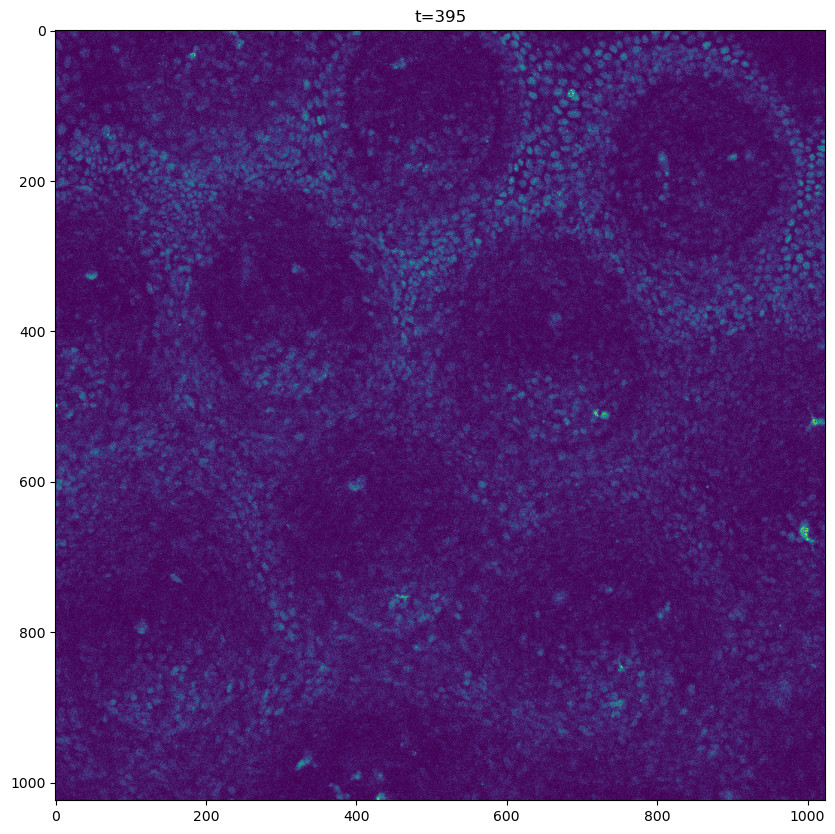

In [3]:
# Function for presenting single layer dynamics over time as .gif

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images

# Update function for video.

# Making video.
#function single_layer_dyn(folder_path::String, filename::String)
    # Read the data saved in .h5 file.
data = read_h5("F:/PhD_Franziska/Headon/Headon_results/mesenchym/headon_video1_layer4.h5")

fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    PyPlot.clf()
    PyPlot.title("t=$(i+1)")
    imshow(Float64.(Gray.(data[:, :, i+1])))
end

myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=600, repeat=false, blit=false)
myanim[:save]("mesenchym_layer_4_v1.gif", writer="pillow")
#end

In [18]:
#=

using PyCall
@pyimport matplotlib.animation as anim
using PyPlot

function make_frame(i, data)
    imshow(data[:, :, i+1])
end

function single_layer_dyn(open_filename::String, save_filename::String)
    data = read_h5(open_filename*".h5")
    
    fig = PyPlot.figure(figsize=(10, 10))
    
    myanim = anim.FuncAnimation(fig, make_frame, frames=size(data, 3), 
                                interval=200, repeat=false, blit=false)
    myanim[:save](save_filename*".gif", writer="pillow")
end

=#

In [17]:
#=
single_layer_dyn("headon_layer_5", "headon_layer_5")
=#

# PIV only with mask for subregion mesenchym
Parameters here for the case of applying subregion of mesenchym formulation of one aggregate

In [2]:
using HDF5
using PyPlot
using Images
include("multi_quickPIV/src/multi_quickPIV.jl")
using Statistics
using ImageAnalysis
include("multiscale_multistep_filter.jl")
using PyCall
@pyimport matplotlib.animation as anim

In [3]:
# parameters for video 1 slice 4 one aggregate!!!
t_start = 30
t_end = 215

# Parameters for mask: 
grid_sizes = ( (3,3), )
scales     = ( ((2,2),(2,2)), ) 
steps      = ( ((1,1),(3,3)), ) 

Δ_low = 3000
α = 1.4

# parameters for PIV
pivparams = multi_quickPIV.setPIVParameters(interSize=(16, 16), searchMargin=(32, 32), step=(8, 8), 
                                            filtFun=(M)->(sum(M)/length(M)))
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

data = read_h5("F:/PhD_Franziska/Headon/Headon_results/mesenchym/headon_video1_layer4.h5")[:, :, t_start:t_end]

1024×1024×186 Array{Float32, 3}:
[:, :, 1] =
    9.0  1166.0  1373.0  1272.0  1328.0  …  1479.0  1801.0  1608.0  2578.0
 1311.0   550.0  1256.0   736.0  1214.0     1839.0  2148.0   503.0  2112.0
  260.0  1044.0   944.0  2798.0   988.0      865.0  1424.0  1230.0  3093.0
   74.0  1254.0   295.0  1022.0  1544.0     2668.0  2188.0  2573.0  1639.0
  306.0   433.0   522.0   584.0   443.0     1685.0  2026.0  3054.0  1546.0
 1411.0  2094.0  1690.0  2889.0  2186.0  …  2171.0  1394.0  1204.0   466.0
  565.0  1001.0  1320.0  2095.0  2479.0     1135.0   649.0    41.0   825.0
 1882.0   306.0   448.0   866.0   402.0       45.0    56.0    44.0   444.0
 1392.0  1528.0   771.0   771.0   550.0      389.0    64.0   324.0   380.0
 1226.0  1531.0  1888.0  2394.0   994.0      595.0    13.0   106.0    47.0
  665.0   511.0   449.0  1224.0  1830.0  …  1188.0   232.0   421.0    51.0
 1363.0   350.0  2385.0  1948.0   962.0      697.0   600.0    41.0   314.0
  930.0  3035.0   852.0  1652.0  1480.0      527.0   86

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


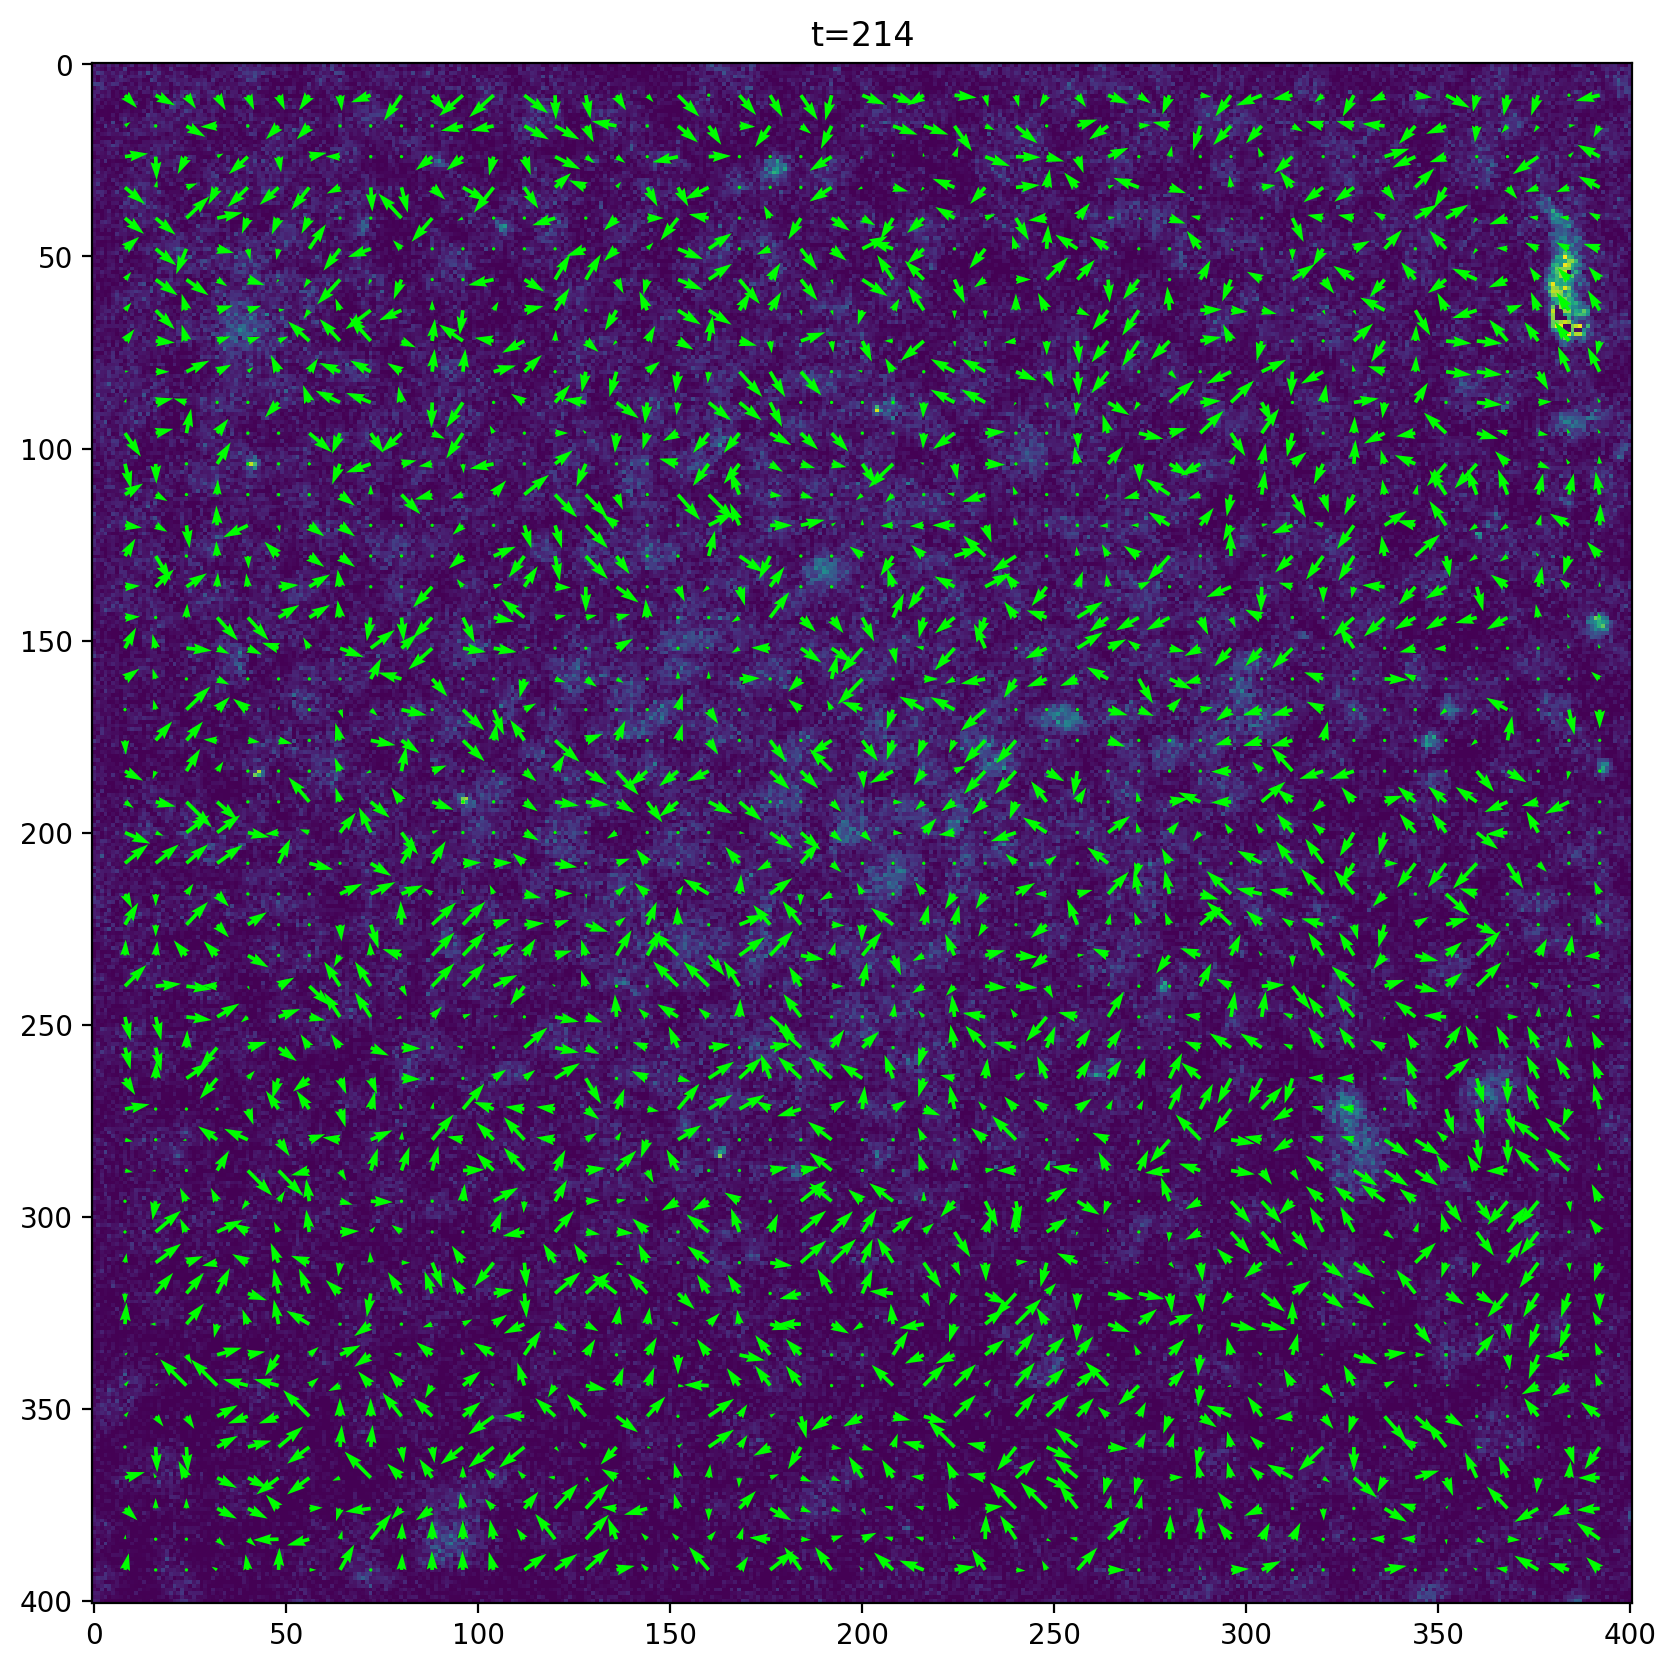

In [4]:
fig = PyPlot.figure(figsize=(10, 10), dpi=200)

function make_frame(i)
    
    PyPlot.clf()
    
    # Taking images.
    img1 = data[:, :, i+1]
    img2 = data[:, :, i+2]

    sub_img1 = Float32.(Gray.(img1[200:600, 150:550]))
    sub_img2 = Float32.(Gray.(img2[200:600, 150:550]))
    
    # # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( sub_img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( sub_img1 .+ Δ_low ) .^ α
    
    # # Running PIV.
    VF, _ = multi_quickPIV.PIV( sub_img1, sub_img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
        
    imshow(sub_img1)
    PyPlot.title("t=$(i+30)")
    PyPlot.quiver( xgrid, ygrid, V, -U, color="lime")
    
end
    
myanim = anim.FuncAnimation(fig, make_frame, frames=size(data,3)-1, 
                            interval=500)
myanim[:save]("v1_s4_aggregate_test.gif", writer="pillow")

In [4]:
using HDF5 

m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:size(data, 3)-1
    
    # Taking images.
    img1 = data[:, :, i]
    img2 = data[:, :, i+1]

    sub_img1 = Float32.(Gray.(img1[200:600, 150:550]))
    sub_img2 = Float32.(Gray.(img2[200:600, 150:550]))
    
    # # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( sub_img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( sub_img1 .+ Δ_low ) .^ α
    
    # # Running PIV.
    VF, _ = multi_quickPIV.PIV( sub_img1, sub_img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 );
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, M)
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

h5open("U_matrix", "w") do file
    write(file, "matrix", U_data)
end

h5open("V_matrix", "w") do file
    write(file, "matrix", V_data)
end

h5open("M_matrix", "w") do file
    write(file, "matrix", M_data)
end

h5open("xgrid_matrix", "w") do file
    write(file, "matrix", xgrid_data)
end

h5open("ygrid_matrix", "w") do file
    write(file, "matrix", ygrid_data)
end

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


# PIV only with mask for whole image mesenchym.

In [ ]:
using HDF5
using PyPlot
using Images
include("multi_quickPIV/src/multi_quickPIV.jl")
using Statistics
using ImageAnalysis
include("multiscale_multistep_filter.jl")

function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end

slices = read_h5("F:/PhD_Franziska/Headon/Headon_results/mesenchym/headon_video1_layer4.h5")

In [ ]:
# Parameters for whole image PIV mesenchym 

# parameter for multiscale multistep filter
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

Δ_low = 3000
α = 1.5

# paramters for PIV analysis
pivparams = multi_quickPIV.setPIVParameters(interSize=(32, 32), searchMargin=(64, 64), step=(16, 16),
                                            filtFun=(M)->(sum(M)/length(M)))
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

In [ ]:
fig = PyPlot.figure(figsize=(10, 10), dpi=200)

function make_frame(i)
    
    PyPlot.clf()
    
    # Taking images.
    img1 = data[:, :, i+1]
    img2 = data[:, :, i+2]
    
    # # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
        
    imshow(img1)
    PyPlot.title("t=$(i+1)")
    PyPlot.quiver( xgrid, ygrid, V, -U, color="aqua")
    
end
    
myanim = anim.FuncAnimation(fig, make_frame, frames=size(data,3)-1, 
                            interval=500)
myanim[:save]("v1_s4_aggregate_test.gif", writer="pillow")

In [ ]:
using HDF5 

m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:size(slices, 3)-1
    
    # Taking images.
    img1 = data[:, :, i]
    img2 = data[:, :, i+1]

    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 );
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, M)
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

h5open("U_matrix", "w") do file
    write(file, "matrix", U_data)
end

h5open("V_matrix", "w") do file
    write(file, "matrix", V_data)
end

h5open("M_matrix", "w") do file
    write(file, "matrix", M_data)
end

h5open("xgrid_matrix", "w") do file
    write(file, "matrix", xgrid_data)
end

h5open("ygrid_matrix", "w") do file
    write(file, "matrix", ygrid_data)
end

In [1]:
# # Function for PIV vector fields. (Causion the orientation y-axis!) 
# # Using 

# using PyCall
# @pyimport matplotlib.animation as anim
# using PyPlot
# using Images
# using multi_quickPIV
# #using VideoIO, FFMPEG
# using ImageBinarization
# using ImageAnalysis

# # intensity of a subregion. 
# function integralArea( intArr::Matrix{Float64}, TL, BR)
#     area = intArr[BR[1],BR[2]] - intArr[BR[1],TL[2]] - intArr[TL[1],BR[2]] + intArr[TL[1],TL[2]]
#     return area
# end

# l_data = read_h5("headon_layer_1.h5")

# #params = multi_quickPIV.setPIVParameters(interSize=(32,32), searchMargin=(16,16))#, step=(16,16), threshold=1000) 
# params = multi_quickPIV.setPIVParameters(interSize=(16, 16))
# IA_size = multi_quickPIV._isize(params)[1:2]
# IA_step = multi_quickPIV._step(params)[1:2]

# fig = PyPlot.figure(figsize=(10, 10))

# function make_frame(i) # Due to Python function i begins with 0!
    
#     PyPlot.clf()
    
#     img1 = Float64.(Gray.(l_data[:, :, i+1]))
#     img2 = Float64.(Gray.(l_data[:, :, i+2]))
    
#     # Mask 
#     img1_b = binarize(img1, Polysegment())
#     img2_b = binarize(img2, Polysegment())
    
#     # Doing PIV
#     VF, SN = multi_quickPIV.PIV(img1_b, img2_b, params)
    
#     U = VF[ 1, :, : ]
#     V = VF[ 2, :, : ]
    
#     xgrid = [(x-1)*IA_step[2] + div(IA_size[2],2) for y in 1:size(U,1), x in 1:size(U,2)] 
#     ygrid = [(y-1)*IA_step[1] + div(IA_size[1],2) for y in 1:size(U,1), x in 1:size(U,2)]
    
#     # Setting arrows on blank IA to be zero.
#     sum_img = ImageAnalysis.integralArray(img1_b, typ = Float64, fun = (x) -> (x))
#     width = Integer(IA_size[1]/2)
#     #sum_subarea = zeros(Float64, size(xgrid))
#     w = size(img1_b)[1]
#     h = size(img1_b)[2]
    
#     for x in 1:size(U)[1]
#         for y in 1:size(U)[2]

#             col = xgrid[x, y]
#             row = ygrid[x, y]

#             TL = max(1, row-width), max(1, col-width)
#             BR = min(h, row+width), min(w, col+width)

#             if integralArea(sum_img, TL, BR) <= 3
#                 U[x, y] = 0
#                 V[x, y] = 0
#             end

#             #sum_subarea[x, y] = integralArea(sum_img, TL, BR)
#         end
#     end

#     PyPlot.title("t=$(i+1)")
#     imshow(img1)
#     #imshow(img1_b)
#     PyPlot.quiver( xgrid, ygrid, V, -1 .* U, color="red", scale=200)
#     #PyPlot.quiver( xgrid, ygrid, U, V, color="red", scale=200 )

# end

# myanim = anim.FuncAnimation(fig, make_frame, frames=size(l_data,3)-1, 
#                             interval=400)
# myanim[:save]("headon_1_piv_f.gif", writer="pillow")
# #myanim[:save]("test_anim.mp4", writer="ffmpeg")
# #myanim[:save]("test_anim.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

# PIV including mask and postprocessing.

In [2]:
using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Images
#using multi_quickPIV
include("multi_quickPIV/src/multi_quickPIV.jl") # Apply the local version of multiquick_PIV -> perhaps different!
using ImageBinarization
using ImageAnalysis
include("multiscale_multistep_filter.jl")
using Statistics

In [3]:
# Parameters for multiscale filtering.
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

# Parameters for mask
Δ_low = 4000 # expected intensity difference between background and signal
#Δ_up = 30000
α = 1.6  # 1.0 - 2.0

# Parameters of quick_PIV
pivparams = multi_quickPIV.setPIVParameters( interSize=(32,32), 
            step=(16,16), threshold=0.2, filtFun=(M)->(sum(M)/length(M)) )
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

# Parameters for postprocessing
std_factor = 3
function postprocess(M::Matrix{Float32})
    meanM = Statistics.mean(M)
    stdM = Statistics.std(M)
    mask_M = M .<= meanM + std_factor * stdM
    M .*= mask_M
    return M
end

# Pick the slice.
slices = read_h5("v1_headon_layer_2.h5")

1024×1024×24 Array{Float64, 3}:
[:, :, 1] =
 1402.0  1387.0  1347.0  1659.0  1493.0  …    49.0    61.0    31.0    20.0
 3530.0  2014.0  2119.0  4768.0  4352.0       60.0   329.0    38.0    24.0
 1558.0  1422.0  3592.0  2834.0  3460.0       34.0    36.0    82.0   864.0
 3335.0  4434.0  1774.0  2629.0  1081.0      444.0    49.0    29.0    34.0
  994.0  2179.0  3149.0  2196.0  2168.0       48.0    85.0    70.0   316.0
 2709.0  3785.0  3873.0  3324.0  3976.0  …    38.0    77.0   804.0    55.0
 3259.0  2193.0  5743.0  1986.0  2779.0        5.0    45.0    30.0    66.0
 2402.0  3360.0  2578.0  2816.0  5472.0       79.0    88.0    37.0    32.0
 3361.0  1626.0  2418.0  2892.0  5944.0       47.0   251.0   676.0    12.0
 2637.0  2713.0  4914.0  4849.0  3141.0       44.0    28.0    33.0    30.0
 1392.0  2632.0  5179.0  2287.0  2294.0  …    47.0    39.0    37.0    74.0
 1878.0  3972.0  2886.0  3261.0  1436.0       20.0     9.0    49.0    38.0
 1104.0  4348.0  2542.0  4817.0  2076.0       15.0    37

In [6]:
size(slices, 3)

24

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


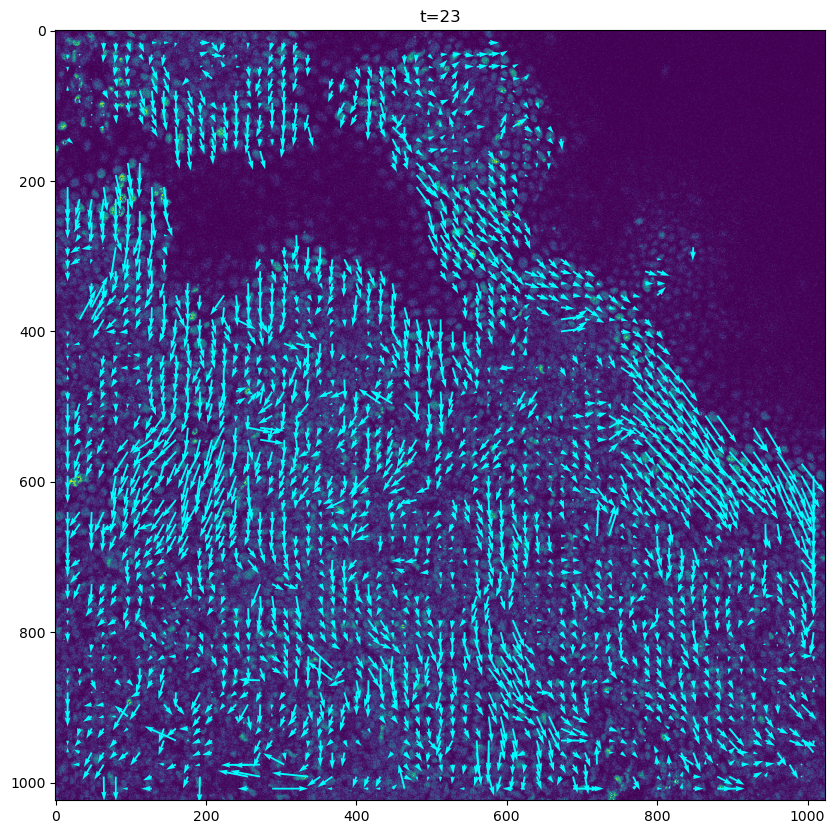

In [7]:
fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    
    PyPlot.clf()
    
    # Taking images.
    img1 = slices[:, :, i+1]
    img2 = slices[:, :, i+2]
    
    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    #mask = (img1 .+ Δ_up) .^α .> out .> ( img1 .+ Δ_low ) .^ α
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[ masked_M .== 0 ] .= NaN
    V[ masked_M .== 0 ] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    imshow(img1)#, cmap="gray")
    #imshow(mask)
    PyPlot.title("t=$(i+1)")
    PyPlot.quiver( xgrid, ygrid, V, -U, color="aqua", scale=150)
    
end
    
myanim = anim.FuncAnimation(fig, make_frame, frames=size(slices,3)-1, 
                            interval=500)
myanim[:save]("headon_2_v1_32_mask.gif", writer="pillow")

### Storing the piv vectors from above

In [10]:
using HDF5 

m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:size(slices, 3)-1
    
    img1 = slices[:, :, i]
    img2 = slices[:, :, i+1]
    
    # Multiscale Mask.
    out = multiscale_multistep_filter( Float32.( img1 ), grid_sizes=grid_sizes, scales=scales, steps=steps )
    mask = out .> ( img1 .+ Δ_low ) .^ α
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV( img1, img2, mask, pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[masked_M .== 0] .= NaN
    V[masked_M .== 0] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, masked_M)
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


LoadError: Type Array does not have a definite size.

In [20]:
h5open("U_matrix", "w") do file
    write(file, "matrix", U_data)
end

In [21]:
function read_h5(folder_path::String, data_name::String)
    h5open(folder_path, "r") do file
        read(file, data_name)
    end
end

read_h5 (generic function with 2 methods)

# Method using movement averaging 

In [1]:
# Read h5 file in which image data is saved. 
using HDF5
include("multiscale_multistep_filter.jl")
include("multi_quickPIV/src/multi_quickPIV.jl")
using PyPlot
using PyCall
@pyimport matplotlib.animation as anim
using Images
using Statistics
using ImageAnalysis


function read_h5(folder_path::String)
    h5open(folder_path, "r") do file
        read(file, "data")
    end
end


read_h5 (generic function with 1 method)

In [38]:
slices = read_h5("F:/PhD_Franziska/Headon/Headon_results/headon_layer_3_v1.h5")[:, :, 17:23]

1024×1024×7 Array{Float32, 3}:
[:, :, 1] =
   80.0    54.0    18.0    38.0   447.0  …   364.0   698.0    34.0    28.0
   55.0   667.0    41.0    64.0    37.0       49.0    57.0    43.0    77.0
   64.0    47.0    64.0   538.0    55.0      332.0   532.0    35.0    16.0
   64.0    38.0    29.0    30.0    26.0       20.0    17.0    23.0     2.0
   31.0    24.0    53.0    35.0    78.0       45.0    39.0    55.0    27.0
   46.0    21.0    48.0    29.0    35.0  …    36.0    27.0    42.0    23.0
   40.0    39.0    34.0    70.0    60.0       35.0    26.0    27.0    28.0
   31.0    27.0    19.0    25.0    32.0       41.0    39.0    40.0    74.0
   46.0    47.0    39.0    38.0    44.0      703.0    89.0    65.0    54.0
   36.0    23.0    50.0    19.0    17.0      135.0    43.0    35.0   189.0
   58.0   255.0   209.0   146.0   462.0  …    60.0    35.0   577.0    17.0
   50.0    40.0    36.0   433.0    22.0       76.0    56.0    50.0    55.0
  804.0    27.0    57.0    53.0    61.0      472.0    75.

In [11]:
pivparams = multi_quickPIV.setPIVParameters( interSize=(32,32), 
            step=(16,16), threshold=0.2, filtFun=(M)->(sum(M)/length(M)) )
IA = multi_quickPIV._isize(pivparams)
ST = multi_quickPIV._step(pivparams)

# Parameters for postprocessing
std_factor = 2
function postprocess(M)
    meanM = Statistics.mean(M)
    stdM = Statistics.std(M)
    mask_M = M .<= meanM + std_factor * stdM
    M .*= mask_M
    return M
end

# Parameters for the mask.
Δ_low = 3000# expected intensity difference between background and signal
α = 1.3# 1.0 - 2.0
grid_sizes = ( (7,7), )
scales     = ( ((4,4),(2,2)), ) 
steps      = ( ((1,1),(4,4)), ) 

(((1, 1), (4, 4)),)

In [4]:
# # Function for averaging the images 
# function fig_average(t, interval)
#     img = slices[:, :, t]
#     if t <= interval
#         img = sum(slices[:, :, i] for i = 1:t)
#         for j in 1:interval
#             img += slices[:, :, t+j]
#         end
#         img /= t + interval
#     elseif size(slices,3) - t < interval
#         img = sum(slices[:, :, i] for i = t:size(slices,3))
#         for j in 1:interval
#             img += slices[:, :, t-j]
#         end
#         img /= interval + size(slices,3) - t + 1
#     else
#         for j in 1:interval
#             img += slices[:, :, t-j] + slices[:, :, t+j]
#         end
#         img /= interval*2+1
#     end
#     return img
# end

# # Function for applying mask on images.
# function img_mask(image)
#     out = multiscale_multistep_filter( image, grid_sizes=grid_sizes, scales=scales, steps=steps )
#     mask = out .> ( image .+ Δ_low ) .^ α
#     return mask
# end

img_mask (generic function with 1 method)

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 


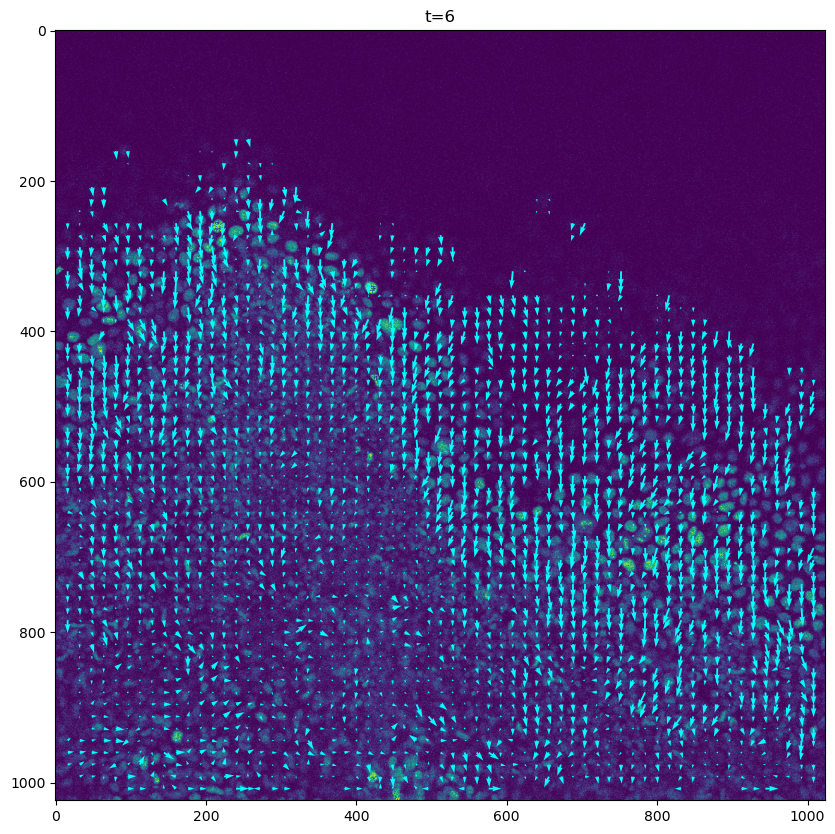

In [39]:
avg_interval = 1
fig = PyPlot.figure(figsize=(10, 10))

function make_frame(i)
    
    PyPlot.clf()
    #=
    if avg_interval-1 < i < size(slices,3)-1-avg_interval
        img1 = img_mask(fig_average(i+1, avg_interval))
        img2 = img_mask(fig_average(i+2, avg_interval))
        print("T")
    else 
        # Taking averaged images and use the mask on it.
        img1 = img_mask(slices[:, :, i+1])
        img2 = img_mask(slices[:, :, i+2])
        print("P")
    end
    =#
    img1 = img_mask(fig_average(i+1, avg_interval))
    img2 = img_mask(fig_average(i+2, avg_interval))

    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV(img1, img2,  pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[ masked_M .== 0 ] .= NaN
    V[ masked_M .== 0 ] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]

    imshow(slices[:, :, i+1])
    #imshow(mask)
    PyPlot.title("t=$(i+1)")
    PyPlot.quiver( xgrid, ygrid, V, -U, color="aqua", scale=120)
    
end
    
myanim = anim.FuncAnimation(fig, make_frame, frames=size(slices,3)-1, 
                            interval=500)
myanim[:save]("test.gif", writer="pillow")

In [41]:
using HDF5 

m_U = Matrix{Float32}[]
m_V = Matrix{Float32}[]
m_xgrid = Matrix{Float32}[]
m_ygrid = Matrix{Float32}[]
m_M = Matrix{Float32}[]

for i in 1:size(slices, 3)-1
    
    img1 = img_mask(fig_average(i, avg_interval))
    img2 = img_mask(fig_average(i+1, avg_interval))
    
    # Running PIV.
    VF, _ = multi_quickPIV.PIV(img1, img2,  pivparams, precision=32 )
    
    U = VF[ 1, :, : ]; 
    V = VF[ 2, :, : ]; 
    M = sqrt.( U .^ 2 .+ V .^ 2 )
    
    # Postprocessing 
    masked_M = postprocess(M)
    
    U[ masked_M .== 0 ] .= NaN
    V[ masked_M .== 0 ] .= NaN
    ygrid = [ ( y - 1 )*ST[1] + div( IA[1], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    xgrid = [ ( x - 1 )*ST[2] + div( IA[2], 2 ) for y in 1:size(U,1), x in 1:size(U,2) ]
    
    push!(m_U, U)
    push!(m_V, V)
    push!(m_xgrid, xgrid)
    push!(m_ygrid, ygrid)
    push!(m_M, masked_M)
end

# Converting dimensions with time.
U_data = reduce((x,y) -> cat(x,y,dims=3), m_U)
V_data = reduce((x,y) -> cat(x,y,dims=3), m_V)
xgrid_data = reduce((x,y) -> cat(x,y,dims=3), m_xgrid)
ygrid_data = reduce((x,y) -> cat(x,y,dims=3), m_ygrid)
M_data = reduce((x,y) -> cat(x,y,dims=3), m_M)

h5open("U_matrix", "w") do file
    write(file, "matrix", U_data)
end

h5open("V_matrix", "w") do file
    write(file, "matrix", V_data)
end

h5open("M_matrix", "w") do file
    write(file, "matrix", M_data)
end

h5open("xgrid_matrix", "w") do file
    write(file, "matrix", xgrid_data)
end

h5open("ygrid_matrix", "w") do file
    write(file, "matrix", ygrid_data)
end

hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
hi 
